# Frame Overlap Tutorial (v0.2.0)

This tutorial demonstrates the new object-oriented API introduced in version 0.2.0 for analyzing neutron Time-of-Flight frame overlap data.

## Overview

The frame_overlap package now provides three main classes:

1. **Data**: Load and process ToF data with convolution, frame overlap, and Poisson sampling
2. **Reconstruct**: Apply deconvolution filters to reconstruct original signals
3. **Analysis**: Fit reconstructed data to extract material parameters

We'll walk through a complete workflow from data loading to material analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from frame_overlap import Data, Reconstruct, Analysis, ParametricScan

# Set up plotting
# plt.style.use('default')
%matplotlib inline

## 1. Data Loading and Processing

First, let's load neutron ToF data. The `Data` class handles both signal and openbeam files.

In [2]:
# Load data from CSV files
data = Data(signal_file='iron_powder.csv',
            openbeam_file='openbeam.csv',
            flux=1e6,           # neutrons/s
            duration=3600,      # seconds
            threshold=00)       # filter stacks < 30

print(data)
print(f"\nLoaded {len(data.table)} data points")
print(f"Time range: {data.table['time'].min():.1f} - {data.table['time'].max():.1f} µs")

Data(n_points=2400, stage='original', has_openbeam=True, kernel=None)

Loaded 2400 data points
Time range: 0.0 - 24.0 µs


### Visualize the raw data

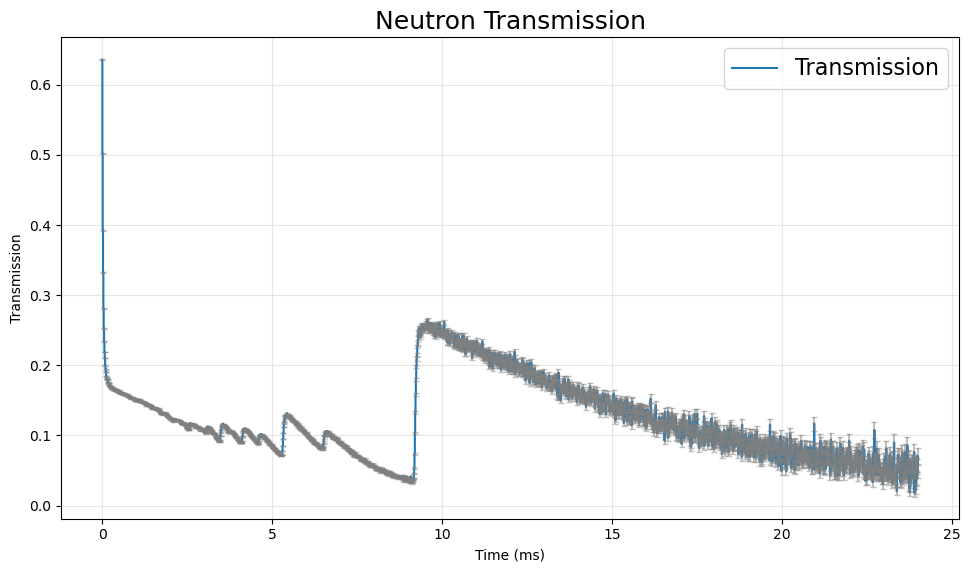

In [3]:
# Plot signal
fig = data.plot()
plt.show()


## 2. Instrument Response Convolution

Simulate the effect of measuring with an instrument that has a finite pulse duration.

In [9]:
# Apply square response convolution (200 µs pulse)
data.convolute_response(pulse_duration=50)

print("Convolution applied")
print(f"Data shape: {data.table.shape}")

ValueError: Length of values (5000) does not match length of index (2400)

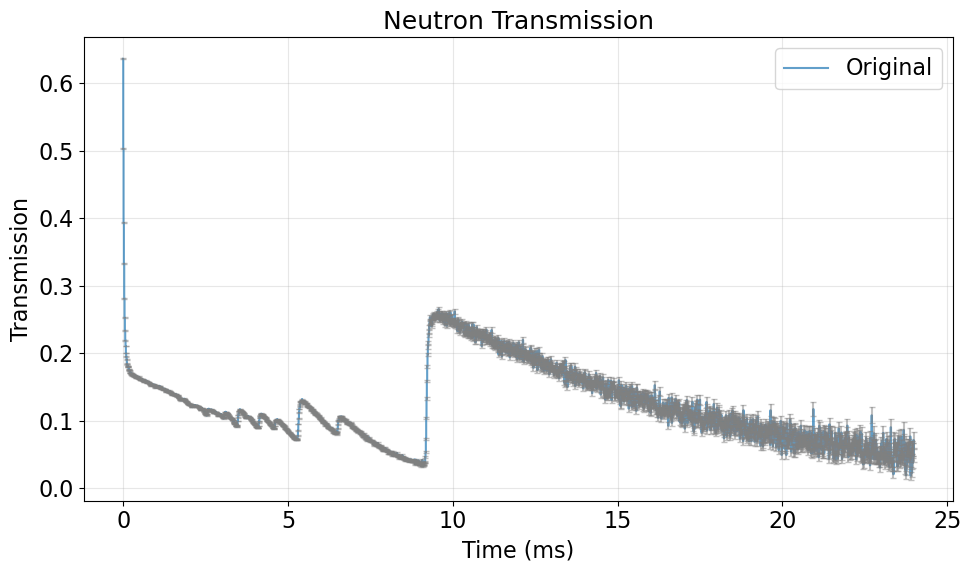

In [8]:
data.plot(show_stages=True,show_errors=True);

## 3. Frame Overlap Creation

Create overlapping frames with a custom time sequence. The sequence `[0, 12, 10, 25]` means:
- Frame 1 starts at t = 0 ms
- Frame 2 starts at t = 12 ms
- Frame 3 starts at t = 12 + 10 = 22 ms
- Frame 4 starts at t = 22 + 25 = 47 ms

Frame overlap created with kernel: [0, 5, 10, 10, 20]
New data length: 5001


Text(0.5, 1.0, 'Data after Frame Overlap')

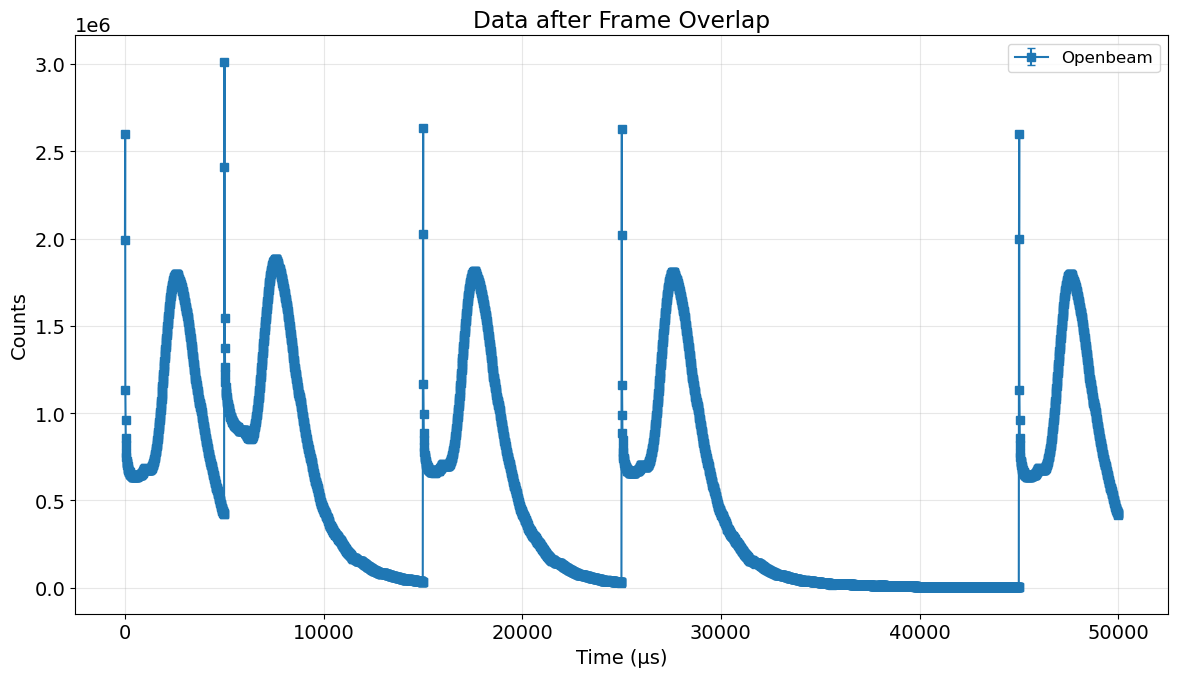

In [20]:
# Create frame overlap
data.overlap(seq=[0,5,10,10,20],total_time=50)

print(f"Frame overlap created with kernel: {data.kernel}")
print(f"New data length: {len(data.table)}")

# Plot overlapped data
fig = data.plot(kind="openbeam")
plt.title('Data after Frame Overlap')

In [21]:
data.kernel

[0, 5, 10, 10, 20]

## 4. Poisson Sampling

Apply Poisson counting statistics to simulate realistic measurement conditions.

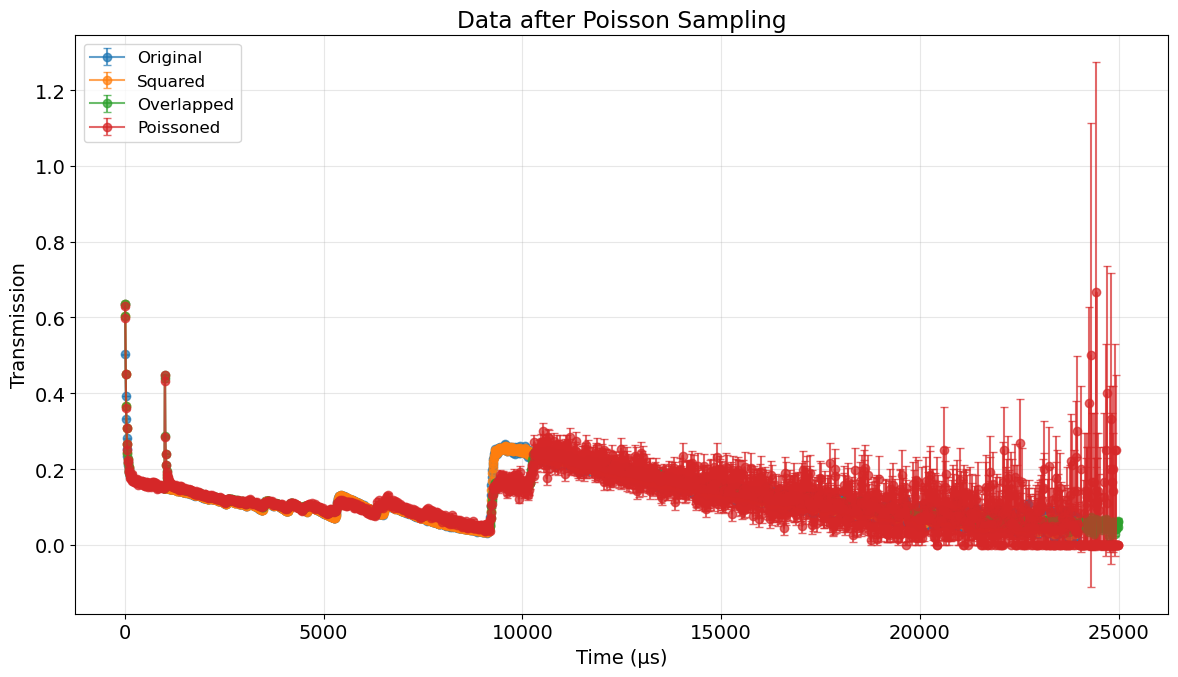

In [54]:
# Apply Poisson sampling with 80% duty cycle
data.poisson_sample(duty_cycle=0.01)

# Plot final processed data
fig = data.plot(show_stages=True)
plt.title('Data after Poisson Sampling')
plt.show()

## 5. Signal Reconstruction

Now we'll use the `Reconstruct` class to deconvolve the overlapped frames and recover the original signal.

In [55]:
data.kernel

[0, 1, 20]

In [56]:
# Create Reconstruct object
recon = Reconstruct(data)

# Apply Wiener filter
recon.filter(kind='wiener', noise_power=0.01)

print("Reconstruction complete")
print(f"\nReconstruction Statistics:")
for key, value in recon.get_statistics().items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Reconstruction complete

Reconstruction Statistics:
  chi2: 373339143.2488
  chi2_per_dof: 155557.9764
  r_squared: -0.1420
  rmse: 72349.1976
  nrmse: 0.0461
  n_points: 2400


### Visualize reconstruction results

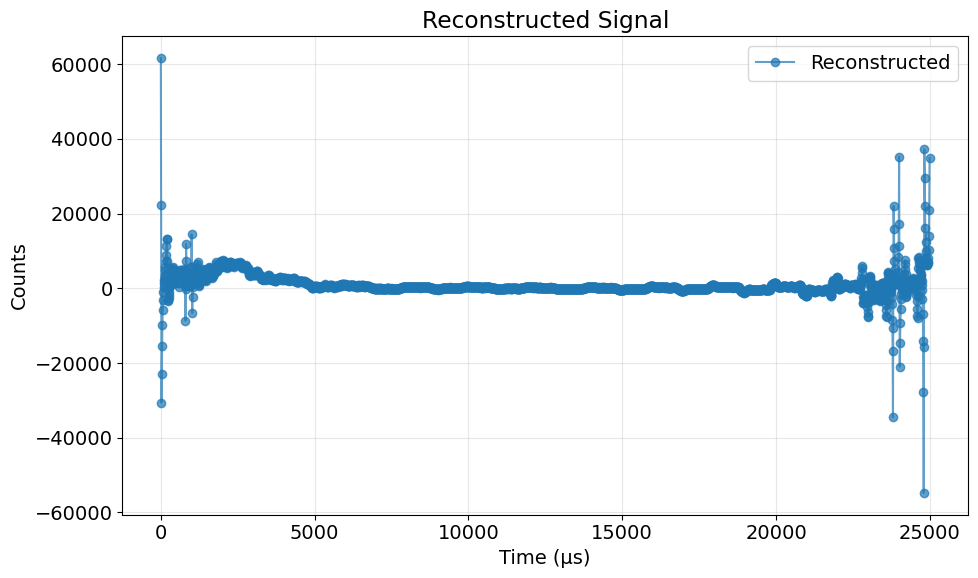

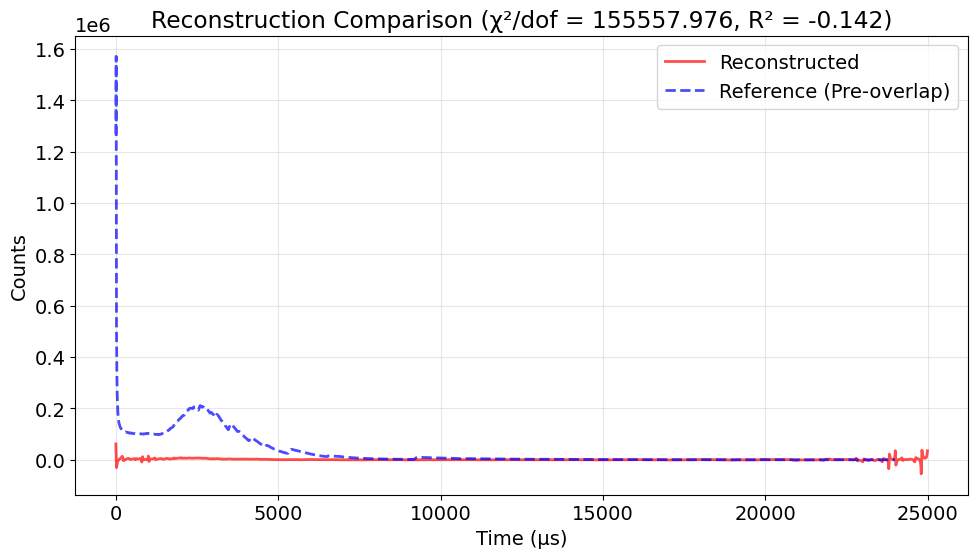

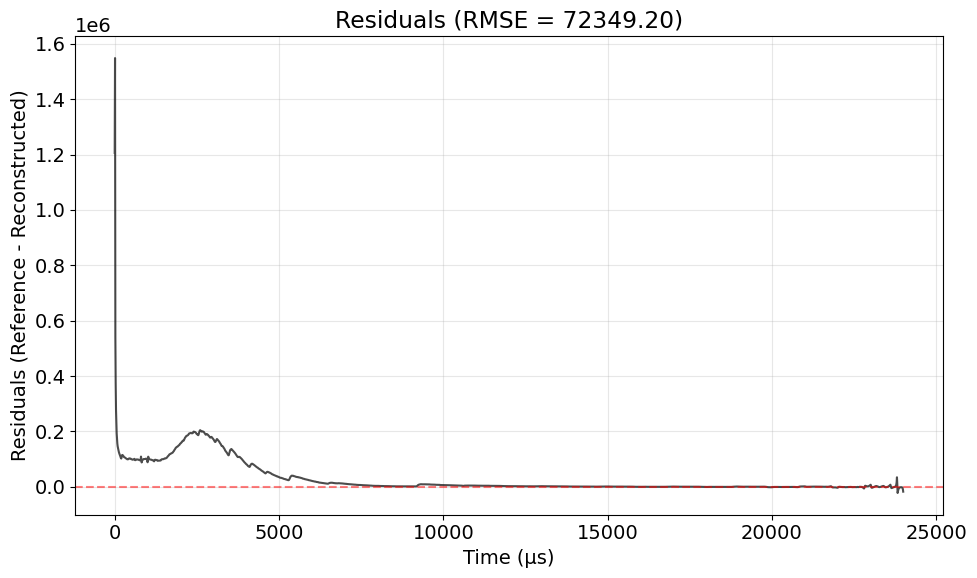

In [57]:
# Plot reconstructed signal
fig = recon.plot_reconstruction()
plt.show()

# Compare with reference (if available)
try:
    fig = recon.plot_comparison()
    plt.show()
    
    fig = recon.plot_residuals()
    plt.show()
except ValueError:
    print("Reference data not available for comparison")

### Try different deconvolution methods

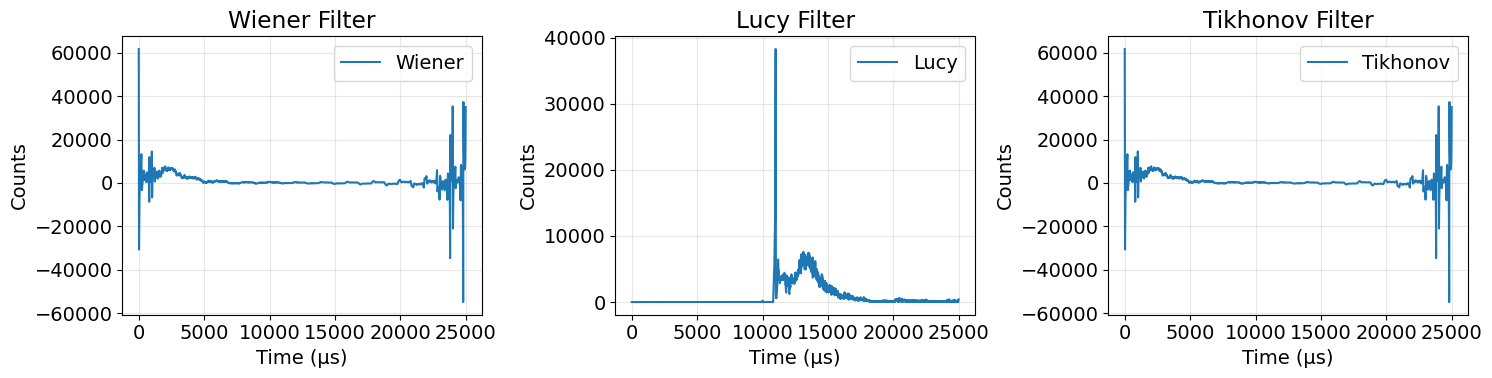

In [59]:
# Compare Wiener, Richardson-Lucy, and Tikhonov methods
methods = ['wiener', 'lucy', 'tikhonov']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, method in zip(axes, methods):
    recon_test = Reconstruct(data)
    recon_test.filter(kind=method, noise_power=0.01, iterations=10)
    
    ax.plot(recon_test.reconstructed_table['time'],
            recon_test.reconstructed_table['counts'],
            label=method.capitalize())
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('Counts')
    ax.set_title(f'{method.capitalize()} Filter')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Material Analysis

Fit the reconstructed data to extract material parameters like thickness and composition.

In [66]:
# Create Analysis object
analysis = Analysis(recon)

# Set material composition (default is Fe-alpha + 4% Cellulose)
analysis.set_cross_section(['Fe_alpha', 'Cellulose'], [0.96, 0.04])

# Fit with square response function
try:
    analysis.fit(response='square')
    
    # Print fit report
    print(analysis.get_fit_report())
except Exception as e:
    print(f"Fitting failed: {e}")
    print("This can happen with random test data")
analysis

[[Model]]
    Model(_square_response)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 2500
    # variables        = 3
    chi-square         = 9.6732e+09
    reduced chi-square = 3873946.03
    Akaike info crit   = 37927.4587
    Bayesian info crit = 37944.9308
    R-squared          = -0.06160890
##  Warning: uncertainties could not be estimated:
[[Variables]]
    thickness:  9.58586100 (init = 1)
    amplitude:  5194572.31 (init = 61657.56)
    weight_0:   0.74895065 (init = 0.96)


ValueError: Invalid format specifier '.2f if thickness is not None else 'N/A'' for object of type 'float'

### Visualize fit results

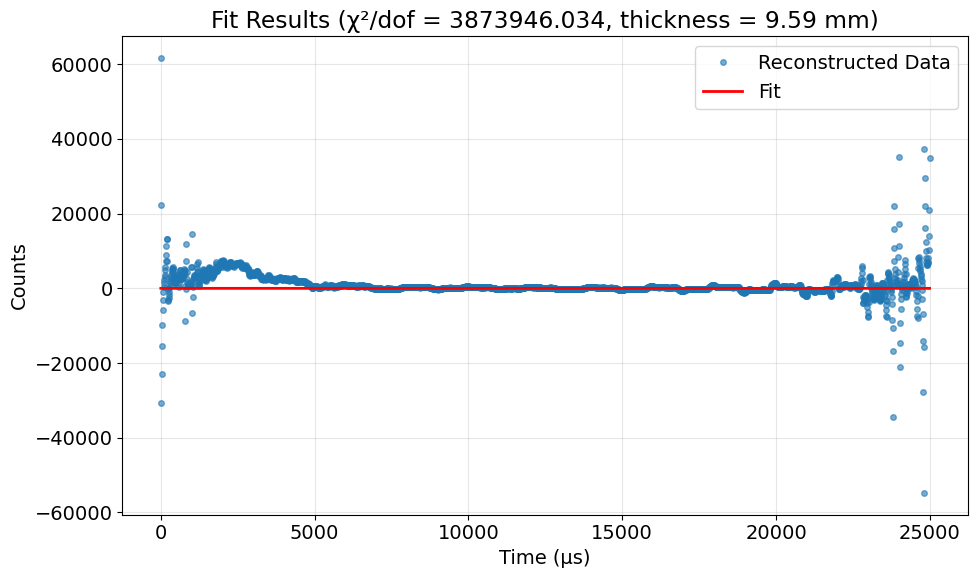

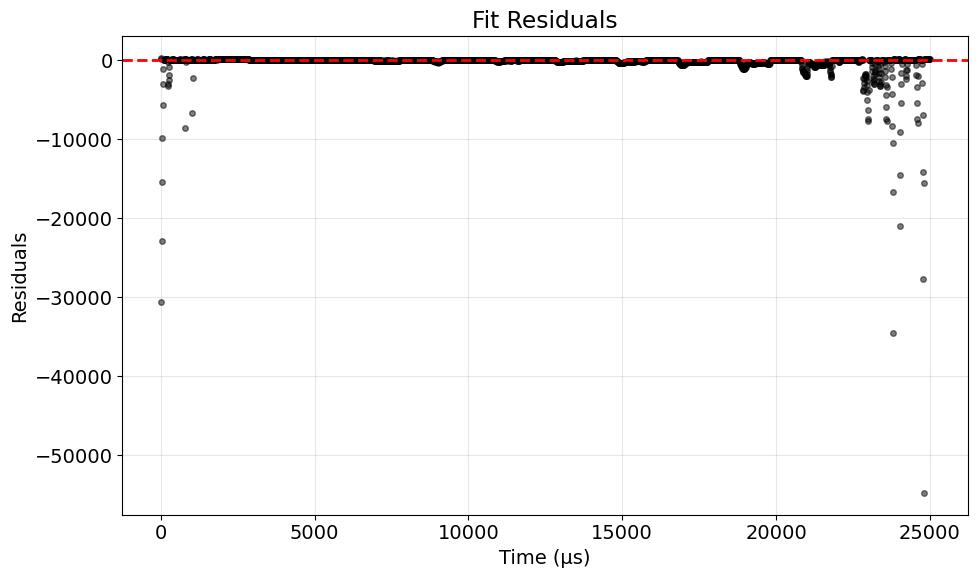

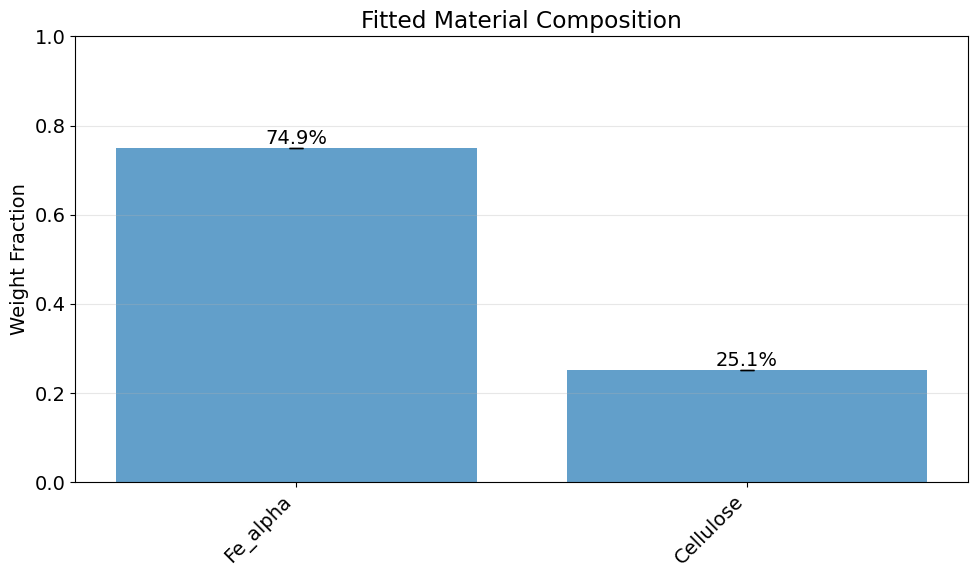

In [67]:
try:
    # Plot fit
    fig = analysis.plot_fit()
    plt.show()
    
    # Plot residuals
    fig = analysis.plot_residuals()
    plt.show()
    
    # Plot material composition
    fig = analysis.plot_materials()
    plt.show()
except (ValueError, AttributeError):
    print("Fit visualization not available")

## 7. Parametric Scans

Explore how different processing parameters affect the reconstruction and fitting results.

In [68]:
# Load fresh data for scanning
scan_data = Data(signal_file='iron_powder.csv', threshold=30)

# Create parametric scan
scan = ParametricScan(scan_data)

# Add parameters to scan
scan.add_parameter('pulse_duration', [100, 200, 300])
scan.add_parameter('n_frames', [2, 3, 4])

print("Running parametric scan...")
print(f"Total combinations: {3 * 3} = 9")

# Run scan (may take a minute)
try:
    scan.run(verbose=True)
    
    # Get results
    results = scan.get_results()
    print(f"\nSuccessful runs: {len(results)} / 9")
    print("\nSample results:")
    print(results[['pulse_duration', 'n_frames', 'recon_r_squared', 'fit_thickness']].head())
except Exception as e:
    print(f"Scan failed: {e}")

Running parametric scan...
Total combinations: 9 = 9
Running combination 1/9: {'pulse_duration': 100, 'n_frames': 2}
Running combination 2/9: {'pulse_duration': 100, 'n_frames': 3}
Running combination 3/9: {'pulse_duration': 100, 'n_frames': 4}
Running combination 4/9: {'pulse_duration': 200, 'n_frames': 2}
Running combination 5/9: {'pulse_duration': 200, 'n_frames': 3}
Running combination 6/9: {'pulse_duration': 200, 'n_frames': 4}
Running combination 7/9: {'pulse_duration': 300, 'n_frames': 2}
Running combination 8/9: {'pulse_duration': 300, 'n_frames': 3}
Running combination 9/9: {'pulse_duration': 300, 'n_frames': 4}

Successful runs: 9 / 9

Sample results:
   pulse_duration  n_frames  recon_r_squared  fit_thickness
0             100         2        -0.436420       9.944583
1             100         3        -5.092568       4.926567
2             100         4       -12.910190       4.751239
3             200         2        -0.383967       4.653403
4             200         3   

### Visualize scan results

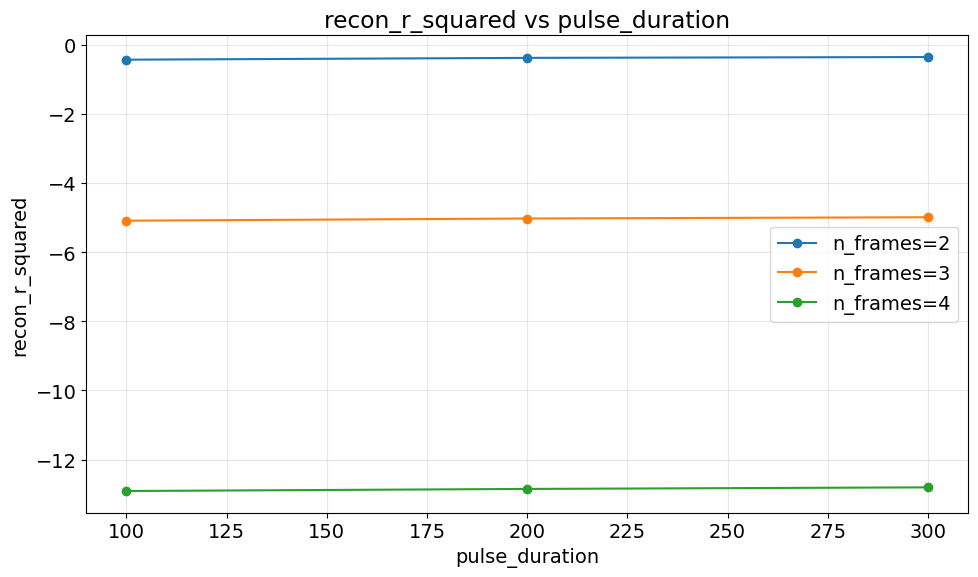

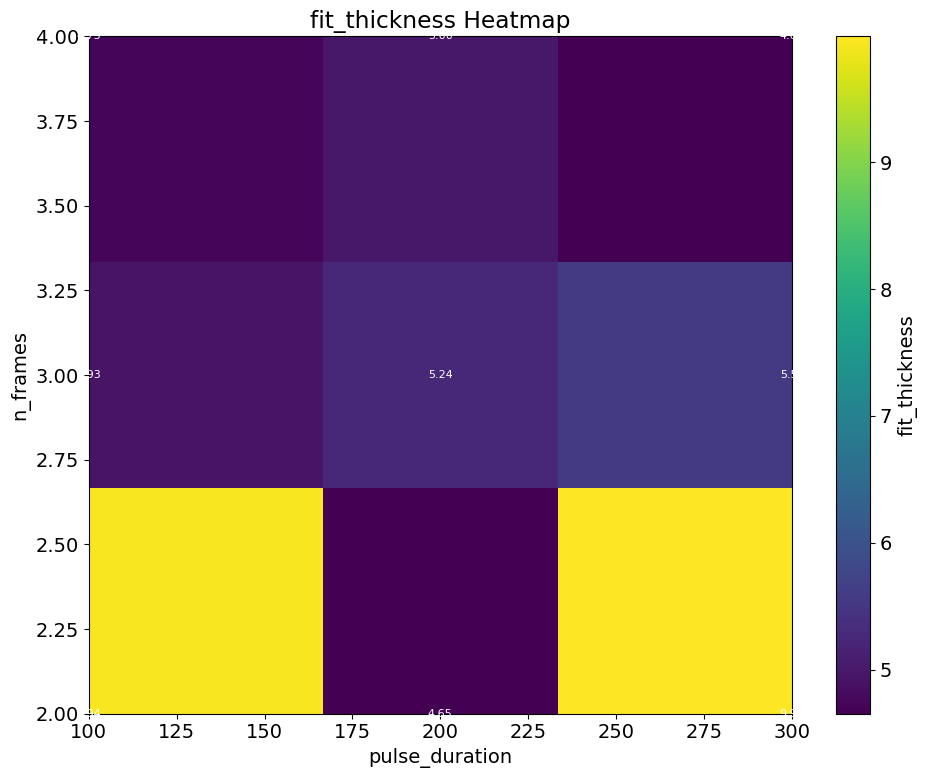

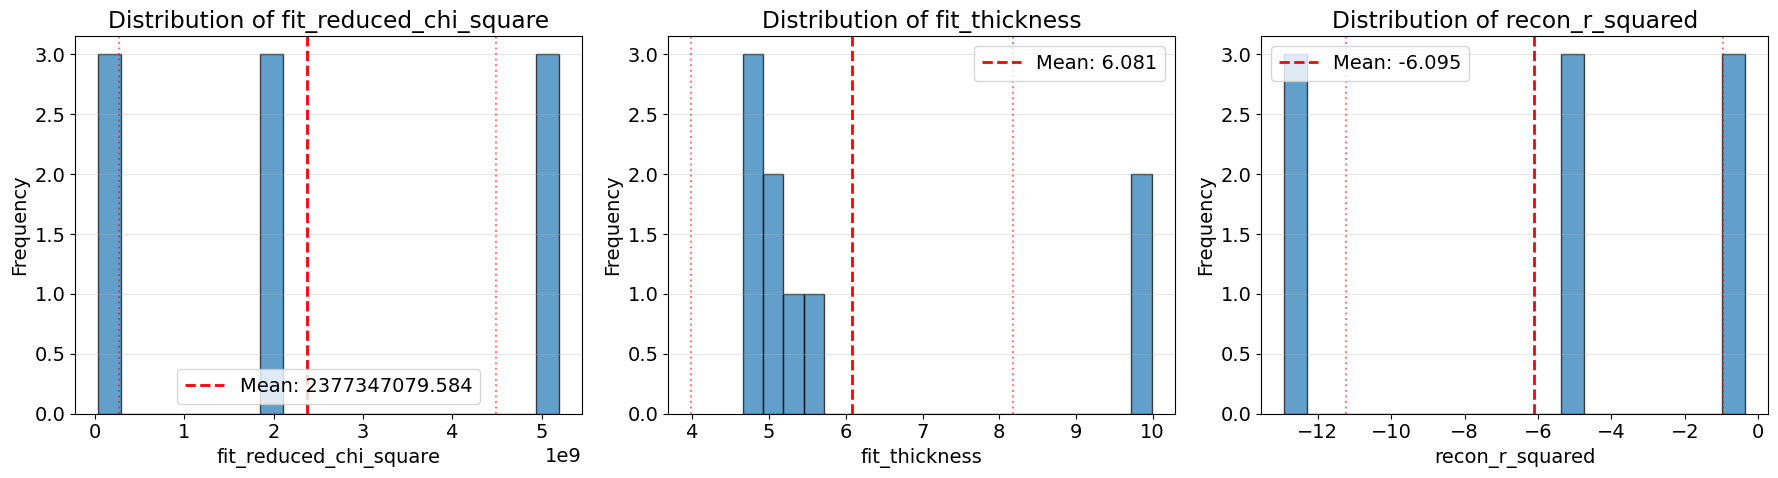

In [69]:
try:
    # Parameter sensitivity plot
    fig = scan.plot_parameter_sensitivity('pulse_duration', 'recon_r_squared', groupby='n_frames')
    plt.show()
    
    # 2D heatmap
    fig = scan.plot_heatmap('pulse_duration', 'n_frames', 'fit_thickness')
    plt.show()
    
    # Summary statistics
    fig = scan.plot_summary()
    plt.show()
except Exception as e:
    print(f"Plotting failed: {e}")

## 8. Method Chaining Example

The new API supports fluent method chaining for concise workflows.

In [70]:
# Complete workflow in a chained style
data_chain = (Data(signal_file='iron_powder.csv', threshold=30)
              .convolute_response(pulse_duration=200)
              .overlap(seq=[0, 12, 10, 25])
              .poisson_sample(duty_cycle=0.8))

print("Data processing complete via method chaining")
print(data_chain)

# Continue with reconstruction
recon_chain = Reconstruct(data_chain).filter(kind='wiener', noise_power=0.01)
print(f"\nReconstruction χ²/dof: {recon_chain.statistics.get('chi2_per_dof', 'N/A')}")

Data processing complete via method chaining
Data(n_points=2371, stage='poissoned', has_openbeam=False, kernel=[0, 12, 10, 25])

Reconstruction χ²/dof: 158174129.48583156


## Summary

This tutorial covered:

1. **Data Loading**: Loading signal and openbeam ToF data
2. **Convolution**: Applying instrument response functions
3. **Frame Overlap**: Creating overlapping frame sequences
4. **Poisson Sampling**: Simulating counting statistics
5. **Reconstruction**: Deconvolving signals with multiple methods
6. **Analysis**: Fitting for material parameters
7. **Parametric Scans**: Exploring parameter sensitivity
8. **Method Chaining**: Concise workflow syntax

The new v0.2.0 API provides a clean, intuitive interface for neutron ToF frame overlap analysis!

## Additional Resources

- Documentation: See README.md for complete API reference
- Legacy API: The v0.1.0 functional API remains available for backward compatibility
- Source code: https://github.com/TsvikiHirsh/frame_overlap